## Training the neck exercise movement detection model

In [ ]:
import os
import json
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from tf_keras.utils import to_categorical
from tf_keras.preprocessing.image import load_img, img_to_array

EXPECTED_NUM_KEYPOINTS = 17

def load_data(data_dir):
    images = []
    keypoints = []
    labels = []

    for exercise_name in os.listdir(data_dir):
        exercise_folder = os.path.join(data_dir, exercise_name)
        if not os.path.isdir(exercise_folder):
            continue

        for sequence_name in os.listdir(exercise_folder):
            sequence_folder = os.path.join(exercise_folder, sequence_name)
            if not os.path.isdir(sequence_folder):
                continue

            for file in os.listdir(sequence_folder):
                if file.endswith(".jpg"):
                    image_path = os.path.join(sequence_folder, file)
                    json_path = image_path.replace(".jpg", ".json")


                    image = load_img(image_path, target_size=(224, 224))
                    image = img_to_array(image) / 255.0
                    images.append(image)

                    with open(json_path, 'r') as f:
                        data = json.load(f)

                    frame_keypoints = []
                    for kp in data.get("keypoints", []):
                        x = kp.get("x", 0)
                        y = kp.get("y", 0)

                        x /= 224.0
                        y /= 224.0
                        frame_keypoints.append((x, y))

                    frame_keypoints = [coord for point in frame_keypoints for coord in point]

                    if len(frame_keypoints) < EXPECTED_NUM_KEYPOINTS * 2:
                        frame_keypoints.extend([0] * (EXPECTED_NUM_KEYPOINTS * 2 - len(frame_keypoints)))
                    elif len(frame_keypoints) > EXPECTED_NUM_KEYPOINTS * 2:
                        frame_keypoints = frame_keypoints[:EXPECTED_NUM_KEYPOINTS * 2]

                    keypoints.append(frame_keypoints)

                    labels.append(exercise_name)

    images = np.array(images)
    keypoints = np.array(keypoints)
    print(f"Shape of images: {images.shape}")
    print(f"Shape of keypoints: {keypoints.shape}")

    scaler = StandardScaler()
    keypoints = scaler.fit_transform(keypoints)

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    class_counts = Counter(labels_encoded)
    print("Class Distribution Before Oversampling:")
    for cls, count in class_counts.items():
        print(f"Class {cls} ({label_encoder.inverse_transform([cls])[0]}): {count}")

    max_samples = max(class_counts.values())
    oversampled_images = []
    oversampled_keypoints = []
    oversampled_labels = []

    for cls in class_counts.keys():
        class_indices = [i for i, lbl in enumerate(labels_encoded) if lbl == cls]
        class_images = images[class_indices]
        class_keypoints = keypoints[class_indices]
        class_labels = [cls] * len(class_indices)

        oversampled_class_images, oversampled_class_keypoints, oversampled_class_labels = resample(
            class_images, class_keypoints, class_labels,
            replace=True, n_samples=max_samples, random_state=42
        )

        oversampled_images.extend(oversampled_class_images)
        oversampled_keypoints.extend(oversampled_class_keypoints)
        oversampled_labels.extend(oversampled_class_labels)

    oversampled_images = np.array(oversampled_images)
    oversampled_keypoints = np.array(oversampled_keypoints)
    oversampled_labels = np.array(oversampled_labels)

    print("\nClass Distribution After Oversampling:")
    oversampled_class_counts = Counter(oversampled_labels)
    for cls, count in oversampled_class_counts.items():
        print(f"Class {cls} ({label_encoder.inverse_transform([cls])[0]}): {count}")

    oversampled_labels = to_categorical(oversampled_labels)

    return oversampled_images, oversampled_keypoints, oversampled_labels, label_encoder

In [ ]:
from tf_keras.models import Model
from tf_keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate
from tf_keras.optimizers import Adam
import numpy as np


def build_combined_model(image_shape, keypoints_shape, num_classes):

    image_input = Input(shape=image_shape, name="image_input")

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(image_input)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = GlobalAveragePooling2D()(x)
    image_features = Dense(32, activation='relu')(x)

    keypoints_input = Input(shape=keypoints_shape, name="keypoints_input")
    y = Dense(32, activation='relu')(keypoints_input)
    y = Dropout(0.3)(y)

    combined = Concatenate()([image_features, y])
    combined = Dense(32, activation='relu')(combined)
    combined = Dropout(0.3)(combined)

    output = Dense(num_classes, activation='softmax', name="output")(combined)

    model = Model(inputs=[image_input, keypoints_input], outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
data_dir = '/content/drive/MyDrive/Exercise Tracking/Augmented Exercise Frames'
images, keypoints, labels, label_encoder = load_data(data_dir)

image_shape = images.shape[1:]
keypoints_shape = keypoints.shape[1]
num_classes = labels.shape[1]

model = build_combined_model(image_shape, keypoints_shape, num_classes)

Shape of images: (1031, 224, 224, 3)
Shape of keypoints: (1031, 34)
Class Distribution Before Oversampling:
Class 1 (Head Turns): 193
Class 0 (Head Rotation): 193
Class 3 (Neck Side bend): 279
Class 2 (Neck Extension): 40
Class 5 (Shoulder Shrug): 156
Class 4 (Neck Stretch): 170

Class Distribution After Oversampling:
Class 1 (Head Turns): 279
Class 0 (Head Rotation): 279
Class 3 (Neck Side bend): 279
Class 2 (Neck Extension): 279
Class 5 (Shoulder Shrug): 279
Class 4 (Neck Stretch): 279


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 112, 112, 32)         4640      ['max_pooling2d[0][0]']   

In [ ]:
from tf_keras.callbacks import ModelCheckpoint
from tf_keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
checkpoint = ModelCheckpoint('exercise_model.h5', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [lr_scheduler, early_stopping, checkpoint]

history = model.fit(
    x=[images, keypoints],
    y=labels,
    epochs=50,
    validation_split=0.2,
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/50
168/168 [==============================] - 78s 456ms/step - loss: 1.8961 - accuracy: 0.1942 - val_loss: 2.1502 - val_accuracy: 0.0567 - lr: 1.0000e-04
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


168/168 [==============================] - 80s 476ms/step - loss: 1.6437 - accuracy: 0.2793 - val_loss: 3.0386 - val_accuracy: 0.1015 - lr: 1.0000e-04
Epoch 3/50
168/168 [==============================] - 74s 441ms/step - loss: 1.4694 - accuracy: 0.3712 - val_loss: 3.2680 - val_accuracy: 0.1075 - lr: 1.0000e-04
Epoch 4/50
168/168 [==============================] - 75s 445ms/step - loss: 1.3608 - accuracy: 0.4257 - val_loss: 3.1927 - val_accuracy: 0.1134 - lr: 1.0000e-04
Epoch 5/50
168/168 [==============================] - 80s 475ms/step - loss: 1.2283 - accuracy: 0.4832 - val_loss: 3.3374 - val_accuracy: 0.1164 - lr: 1.0000e-04
Epoch 6/50
168/168 [==============================] - 76s 451ms/step - loss: 1.1308 - accuracy: 0.5258 - val_loss: 3.5735 - val_accuracy: 0.1343 - lr: 1.0000e-04
Epoch 7/50
168/168 [==============================] - 74s 438ms/step - loss: 1.0643 - accuracy: 0.5534 - val_loss: 3.5618 - val_accuracy: 0.1164 - lr: 1.0000e-04
Epoch 8/50
168/168 [===================

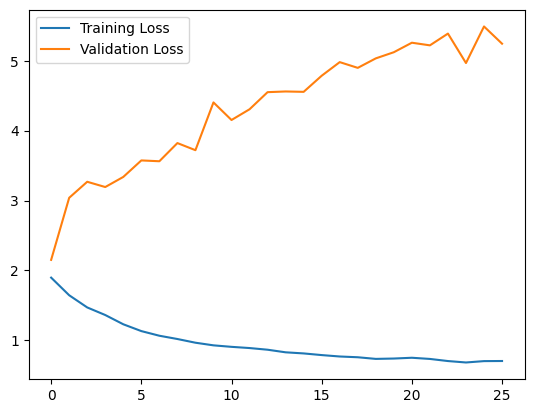

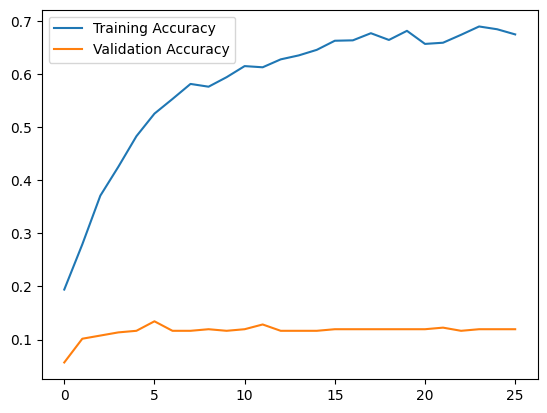

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x=[images[int(len(images)*0.8):], keypoints[int(len(keypoints)*0.8):]], y=labels[int(len(labels)*0.8):], verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

predictions = model.predict([images[int(len(images)*0.8):], keypoints[int(len(keypoints)*0.8):]])

predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(labels[int(len(labels)*0.8):], axis=1)

for i in range(10):
    print(f"Predicted class: {predicted_classes[i]}, True class: {true_classes[i]}")

Validation Loss: 2.1502
Validation Accuracy: 0.0567
11/11 [==============================] - 7s 580ms/step
Predicted class: 0, True class: 5
Predicted class: 0, True class: 5
Predicted class: 0, True class: 5
Predicted class: 0, True class: 5
Predicted class: 0, True class: 5
Predicted class: 5, True class: 5
Predicted class: 0, True class: 5
Predicted class: 2, True class: 5
Predicted class: 2, True class: 5
Predicted class: 5, True class: 5


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_)
print(report)

                precision    recall  f1-score   support

 Head Rotation       0.00      0.00      0.00         0
    Head Turns       0.00      0.00      0.00         0
Neck Extension       0.00      0.00      0.00         0
Neck Side bend       0.00      0.00      0.00         0
  Neck Stretch       1.00      0.04      0.08       279
Shoulder Shrug       0.13      0.14      0.13        56

      accuracy                           0.06       335
     macro avg       0.19      0.03      0.04       335
  weighted avg       0.85      0.06      0.09       335



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
